# 원티드 채용 공고 분석 프로젝트

In [374]:
import sys 
import os  

import pandas as pd  
import numpy as np


from bs4 import BeautifulSoup   
from selenium import webdriver   
from selenium.webdriver.common.keys import Keys
import chromedriver_autoinstaller 

import time    
from tqdm import tqdm_notebook

# 워닝 무시
import warnings
warnings.filterwarnings('ignore')

## 1. 전체 공고 목록의 정보 가져오기

### 1.1 전체 공고 목록과 개별 공고 URL 크롤링

In [290]:
keyword = '데이터 분석가'
keyword

'데이터 분석가'

In [309]:
# 크롬 웹 브라우저 실행 (keyword 검색결과)
chrome_path = chromedriver_autoinstaller.install()
driver = webdriver.Chrome(chrome_path)
driver.get('https://www.wanted.co.kr/search?query={}'.format(keyword)) # Query parameter로 직접 keyword 넣는 방식

In [310]:
# 스크롤을 밑으로 내려주는 함수
def scroll_down(driver):
    driver.execute_script("window.scrollTo(0, 99999999)")
    time.sleep(1)

# n: 스크롤할 횟수 설정 -> 공고 수가 많지 않아 대략적으로 반복횟수 설정함
n = 5
i = 0
while i < n: 
    scroll_down(driver)
    i = i+1
    time.sleep(1)

In [311]:
# 각 공고의 url 가져오기
urls = '.Card_className__u5rsb > a'
url_raw  = driver.find_elements_by_css_selector(urls)

# url만 가져오기
url_list=[]
for url in url_raw:
    url = url.get_attribute('href')
    url_list.append(url)
    
print(url_list[0])
print('url 갯수 :',len(url_list))

https://www.wanted.co.kr/wd/78265
url 갯수 : 58


In [312]:
# 채용공고 타이틀 가져오기
positions = '.job-card-position'
position_raw= driver.find_elements_by_css_selector(positions)

# 채용공고 타이틀 text 변환
position_list = []
for position in position_raw:
    position = position.text
    position_list.append(position)
    
print(position_list[0])
print('postion 갯수 :',len(position_list))

데이터 분석가 (주니어~시니어급)
postion 갯수 : 58


In [313]:
# 회사명 가져오기
names = '.job-card-company-name'
name_raw= driver.find_elements_by_css_selector(names)

# 회사명 text 변환
name_list = []
for name in name_raw:
    name = name.text
    name_list.append(name)
    
print(name_list[0])
print('name 갯수 :',len(name_list))

그로비
name 갯수 : 58


In [314]:
# 관심 수 가져오기
likes = '.likeButton'
like_raw= driver.find_elements_by_css_selector(likes)


# 관심 수 text 변환 후 int 변환
like_list = []
for like in like_raw:
    like = int(like.text) # text로 변환 후 int로 자료형 변경 -> 추후 관심 수로 정렬하기 위함
    like_list.append(like)
    
print(like_list[0])
print('관심 수 표시:',len(like_list))

27
관심 수 표시: 58


### 1.2 데이터프레임 생성

In [315]:
df = pd.DataFrame({'url':url_list,'회사명':name_list,'타이틀':position_list,'관심':like_list})
df.style.set_properties(**{'background-color': 'yellow','text-align':'right'}) ## 오른쪽 정렬
df.head()

,url,회사명,타이틀,관심
0,https://www.wanted.co.kr/wd/78265,그로비,데이터 분석가 (주니어~시니어급),27
1,https://www.wanted.co.kr/wd/58377,아이네블루메(채티),데이터 분석가,3
2,https://www.wanted.co.kr/wd/71455,플라이셔(Flysher),게임 데이터 분석가,27
3,https://www.wanted.co.kr/wd/85810,아우름플래닛(LINER),데이터 분석가,4
4,https://www.wanted.co.kr/wd/71766,이제이엔(EJN),[데이터신사업] 데이터 분석가(4년 이상),1


In [316]:
df.sort_values('관심', ascending=False).head() # 관심 수로 정렬

,url,회사명,타이틀,관심
18,https://www.wanted.co.kr/wd/33147,마이리얼트립,데이터 분석가,349
35,https://www.wanted.co.kr/wd/30355,매스프레소(콴다),Data Analyst (데이터 분석가),292
43,https://www.wanted.co.kr/wd/42707,쏘카(SOCAR),데이터 분석가/사이언티스트,253
25,https://www.wanted.co.kr/wd/39858,와이즐리컴퍼니,데이터 분석가,138
23,https://www.wanted.co.kr/wd/65223,당근마켓,프로덕트 데이터 분석가,100


### 1.3 CSV 파일로 저장하기

In [317]:
df.to_csv('wanted_url.csv', encoding='utf-8-sig')

## 2. 각 공고의 세부 사항 가져오기

### 2.1 csv 파일 로드 후 웹 드라이버 실행

In [318]:
# url csv 파일 로드
url_load = pd.read_csv('wanted_url.csv',encoding='utf-8-sig')
url_load = url_load.drop('Unnamed: 0',axis=1)
num_list = len(url_load)
print(num_list)

58


In [319]:
# 웹드라이버 실행
chrome_path = chromedriver_autoinstaller.install()
driver = webdriver.Chrome(chrome_path)

i = 0
url = url_load['url'][i]
driver.get(url)
time.sleep(1)

### 2.2 목표 데이터 크롤링 test

In [320]:
# 제목 크롤링 시작
pos = driver.find_element_by_class_name('JobHeader_className__HttDA>h2')   # title
position = pos.text  # 셀레늄 덩어리 안의 텍스트 가져오기
position

'데이터 분석가 (주니어~시니어급)'

In [321]:
# 회사명 크롤링 시작
company_name = driver.find_element_by_css_selector('.JobHeader_className__HttDA > div > h6')
name = company_name.text
name

'그로비'

In [322]:
# 주요업무 크롤링
descriptions = driver.find_element_by_css_selector('.JobDescription_JobDescription__VWfcb>p:nth-child(3) > span')
description = descriptions.text
description

'• 경쟁사 분석 및 B2B 마케팅 데이터를 활용한 전략 수립 및 실행\n• 서비스 데이터 (User/Product 등) 분석 및 가공\n• 매출, 결제 등 데이터를 기반으로 한 다양한 분석 업무\n• 데이터 연계를 통한 분석 시사점 발굴 및 분석 서비스 적용 방안 수립\n• 수요예측 및 개인화 추천 기반 분석 및 컨설팅\n• 머신러닝 / 딥러닝을 활용한 데이터 분석 및 분석 결과 기반 인사이트 도출 (시각화, 리포트 등)'

In [323]:
# 자격요건 크롤링
requirements = driver.find_element_by_css_selector('.JobDescription_JobDescription__VWfcb>p:nth-child(5) > span')
requirement = requirements.text
requirement

'• 경력 : 데이터 분석 경험 (신입 또는 경력(1~2년 미만))\n• 데이터 분석을 통해 가설/이론을 수립하고 시장/사업에 적용한 경험이 있는 분\n• SQL을 이용해 데이터 조회/추출/분석이 가능하신 분\n• 데이터 기반의 수익 모델을 수립하거나 운영해보신 분\n• 통계, 분석 관련 업무 지식 및 프로그램 운용 능력(Python 등)'

In [324]:
# 우대사항 크롤링
preferreds = driver.find_element_by_css_selector('.JobDescription_JobDescription__VWfcb>p:nth-child(7) > span')
preferred = preferreds.text
preferred

'• 데이터 분석 관련 직무 유 경험자 (관련 업무 2~3년)\n• 데이터 시각화 프로그래밍 경험\n• E-Commerce 기반의 커머스/개인화 데이터 분석 경험\n• 탐색적 데이터 분석(Exploratory Data Analysis, EDA) 및 시계열 데이터 분석(Time Series Data Analysis) 경험\n• 개발/비개발 직군과의 원활한 커뮤니케이션 및 협업 능력\n• “왜”를 설득시킬 수 있는 대화 능력과 데이터 기반의 의사소통 능력을 가지신 분'

In [325]:
# 관심 수 크롤링
likes = driver.find_element_by_css_selector('.likes>span')
like = int(likes.text)
like

27

In [326]:
target_dict = {}  # 전체 크롤링 데이터를 담을 그릇
target_info = {}  # 개별 블로그 내용을 담을 딕셔너리 생성

In [327]:
target_info['position'] = position
target_info['name'] = name
target_info['description'] = description
target_info['requirement'] = requirement
target_info['preferred'] = preferred
target_info['like'] = like
target_dict[0] = target_info

In [328]:
target_dict

{0: {'position': '데이터 분석가 (주니어~시니어급)',
  'name': '그로비',
  'description': '• 경쟁사 분석 및 B2B 마케팅 데이터를 활용한 전략 수립 및 실행\n• 서비스 데이터 (User/Product 등) 분석 및 가공\n• 매출, 결제 등 데이터를 기반으로 한 다양한 분석 업무\n• 데이터 연계를 통한 분석 시사점 발굴 및 분석 서비스 적용 방안 수립\n• 수요예측 및 개인화 추천 기반 분석 및 컨설팅\n• 머신러닝 / 딥러닝을 활용한 데이터 분석 및 분석 결과 기반 인사이트 도출 (시각화, 리포트 등)',
  'requirement': '• 경력 : 데이터 분석 경험 (신입 또는 경력(1~2년 미만))\n• 데이터 분석을 통해 가설/이론을 수립하고 시장/사업에 적용한 경험이 있는 분\n• SQL을 이용해 데이터 조회/추출/분석이 가능하신 분\n• 데이터 기반의 수익 모델을 수립하거나 운영해보신 분\n• 통계, 분석 관련 업무 지식 및 프로그램 운용 능력(Python 등)',
  'preferred': '• 데이터 분석 관련 직무 유 경험자 (관련 업무 2~3년)\n• 데이터 시각화 프로그래밍 경험\n• E-Commerce 기반의 커머스/개인화 데이터 분석 경험\n• 탐색적 데이터 분석(Exploratory Data Analysis, EDA) 및 시계열 데이터 분석(Time Series Data Analysis) 경험\n• 개발/비개발 직군과의 원활한 커뮤니케이션 및 협업 능력\n• “왜”를 설득시킬 수 있는 대화 능력과 데이터 기반의 의사소통 능력을 가지신 분',
  'like': 27}}

In [329]:
target_info

{'position': '데이터 분석가 (주니어~시니어급)',
 'name': '그로비',
 'description': '• 경쟁사 분석 및 B2B 마케팅 데이터를 활용한 전략 수립 및 실행\n• 서비스 데이터 (User/Product 등) 분석 및 가공\n• 매출, 결제 등 데이터를 기반으로 한 다양한 분석 업무\n• 데이터 연계를 통한 분석 시사점 발굴 및 분석 서비스 적용 방안 수립\n• 수요예측 및 개인화 추천 기반 분석 및 컨설팅\n• 머신러닝 / 딥러닝을 활용한 데이터 분석 및 분석 결과 기반 인사이트 도출 (시각화, 리포트 등)',
 'requirement': '• 경력 : 데이터 분석 경험 (신입 또는 경력(1~2년 미만))\n• 데이터 분석을 통해 가설/이론을 수립하고 시장/사업에 적용한 경험이 있는 분\n• SQL을 이용해 데이터 조회/추출/분석이 가능하신 분\n• 데이터 기반의 수익 모델을 수립하거나 운영해보신 분\n• 통계, 분석 관련 업무 지식 및 프로그램 운용 능력(Python 등)',
 'preferred': '• 데이터 분석 관련 직무 유 경험자 (관련 업무 2~3년)\n• 데이터 시각화 프로그래밍 경험\n• E-Commerce 기반의 커머스/개인화 데이터 분석 경험\n• 탐색적 데이터 분석(Exploratory Data Analysis, EDA) 및 시계열 데이터 분석(Time Series Data Analysis) 경험\n• 개발/비개발 직군과의 원활한 커뮤니케이션 및 협업 능력\n• “왜”를 설득시킬 수 있는 대화 능력과 데이터 기반의 의사소통 능력을 가지신 분',
 'like': 27}

### 2.3 목표 데이터 크롤링 코드

In [330]:
# for문으로 전체 범위 구조화

target_dict = {}    # 전체 크롤링 데이터를 담을 그릇

# 수집할 글 갯수 정하기
number = num_list

# 수집한 url 돌면서 데이터 수집
for i in tqdm_notebook(range(0, number)):
    # 글 띄우기
    url = url_load['url'][i]
    chrome_path = chromedriver_autoinstaller.install()
    driver = webdriver.Chrome(chrome_path)

    driver.get(url)   # 글 띄우기
    time.sleep(1)
    # 크롤링
    # 예외 처리
    try : 
        target_info = {}  # 개별 블로그 내용을 담을 딕셔너리 생성

        # 제목 크롤링
        pos = driver.find_element_by_class_name('JobHeader_className__HttDA>h2')   # title
        position = pos.text  # 셀레늄 덩어리 안의 텍스트 가져오기
        position
        # 사명 크롤링
        company_name = driver.find_element_by_css_selector('.JobHeader_className__HttDA > div > h6')
        name = company_name.text
        name

        # 주요 업무 크롤링
        descriptions = driver.find_element_by_css_selector('.JobDescription_JobDescription__VWfcb>p:nth-child(3) > span')
        description = descriptions.text
        description
        
        # 자격요건 크롤링
        requirements = driver.find_element_by_css_selector('.JobDescription_JobDescription__VWfcb>p:nth-child(5) > span')
        requirement = requirements.text
        requirement
        
        # 우대사항 크롤링
        preferreds = driver.find_element_by_css_selector('.JobDescription_JobDescription__VWfcb>p:nth-child(7) > span')
        preferred = preferreds.text
        preferred
        
        # 관심 수 크롤링
        likes = driver.find_element_by_css_selector('.likes>span')
        like = int(likes.text)
        like
        
        # 글 하나는 target_info라는 딕셔너리에 담기게 되고,
        target_info['position'] = position
        target_info['name'] = name
        target_info['description'] = description
        target_info['requirement'] = requirement
        target_info['preferred'] = preferred
        target_info['like'] = like

        # 각각의 글은 target_dict라는 딕셔너리에 담기게 됩니다.
        target_dict[i] = target_info
        time.sleep(1)
        
        # 크롤링이 성공하면 글 제목을 출력하게 되고,
        print(i, position)

        # 글 하나 크롤링 driver.close() 
       # 에러나면 현재 크롬창을 닫고 다음 글(i+1)로 이동합니다.
    except:
        # print("에러",i, title)
        driver.close()
        time.sleep(1)
        continue
        
        # 중간,중간에 파일로 저장하기
    if i == 30 or i==50 or i==80:
        # 판다스로 만들기
        import pandas as pd
        result_df = pd.DataFrame.from_dict(target_dict, 'index')
        # 저장하기
        result_df.to_csv("wanted_content.csv", encoding='utf-8-sig')
        time.sleep(3)

print('수집한 글 갯수: ', len(target_dict))
print('작업이 완료되었습니다.')

  0%|          | 0/58 [00:00<?, ?it/s]

0 데이터 분석가 (주니어~시니어급)
1 데이터 분석가
2 게임 데이터 분석가
3 데이터 분석가
4 [데이터신사업] 데이터 분석가(4년 이상)
5 데이터 분석가 (Data Analyst)
6 데이터 분석가(Data Analyst/Product Analyst)
7 데이터 분석가(컴플라이언스)
8 데이터 분석가
9 Data Analyst (데이터 분석가)
10 머신러닝 엔지니어 / ML 엔지니어 (데이터 분석가)
11 데이터 분석가(DA)
12 데이터 분석가 / Data Scientist
13 데이터 분석가 (Senior)
14 [Search팀] 데이터 분석가(분석 및 컨버전 엔지니어링)
15 지그재그 데이터 분석가(서비스, 유저분석)
16 지그재그 데이터 분석가(수익화, 셀러 분석)
17 데이터 분석가 (Data Analyst)
18 데이터 분석가
19 시니어 데이터 분석가 (Data Analyst)
20 타다(TADA) 데이터 분석가
21 데이터 분석가 (Data Analyst)
22 비즈니스 데이터 분석가
23 프로덕트 데이터 분석가
24 데이터 분석가 (Data Analyst)
25 데이터 분석가
26 [랩스] 데이터 분석가 (Data Analyst)
27 데이터 분석가
28 [삼쩜삼] 데이터 분석가
29 [무신사-솔드아웃] 데이터 분석가(Product Data Analyst)
30 콘텐츠 데이터 분석가
31 데이터 분석가
32 서비스 데이터 분석가 (2년이상)
33 데이터 분석가(3년 이상)
34 데이터 분석가 (Data Analyst)
35 Data Analyst (데이터 분석가)
36 데이터 분석가(Data Analyst)-2년이상
37 데이터 분석가
38 [쿠키런: 오븐브레이크] 데이터 분석가
39 [쿡앱스] 데이터 분석가 (3년이상)
40 데이터 분석가
41 데이터 분석가(Data Analyst)
42 빅데이터 분석가
43 데이터 분석가/사이언티스트
44 데이터 분석가
45 데이터 분석가
46 [디코드] 데이터 분석가(Data Analyst)
47

### 2.4 데이터프레임 생성

In [331]:
result_df = pd.DataFrame.from_dict(target_dict, orient='index')
result_df

,position,name,description,requirement,preferred,like
0,데이터 분석가 (주니어~시니어급),그로비,• 경쟁사 분석 및 B2B 마케팅 데이터를 활용한 전략 수립 및 실행\n• 서비스 ...,• 경력 : 데이터 분석 경험 (신입 또는 경력(1~2년 미만))\n• 데이터 분석...,• 데이터 분석 관련 직무 유 경험자 (관련 업무 2~3년)\n• 데이터 시각화 프...,27
1,데이터 분석가,아이네블루메(채티),"• 데이터 추출, 분석하여 고객 행동에 대한 가설을 검증하고 주요 인사이트 도출\n...",• 3년 이상의 모바일 앱 및 웹의 고객 행동 데이터 분석을 통한 서비스 개선 경험...,• 웹/앱 이벤트 로그를 적재할 플랫폼 및 적재 형태를 고민하고 엔지니어와 협업한 ...,3
2,게임 데이터 분석가,플라이셔(Flysher),• 로그 설계 : 게임을 플레이하며 의사결정에 필요할 정보를 DB에 어떻게 쌓을지 ...,• 유관 업무 경력 3~5년인 분\n• SQL(Redshift)에 능숙한 분\n• ...,• 직무 관련 전공자 (컴퓨터공학/통계/수학 등)\n• Cloud(AWS 등) 개발...,27
3,데이터 분석가,아우름플래닛(LINER),- 서비스 지표 상승 그리고 프로덕트 개선을 위해 데이터 기반의 인사이트 도출\n-...,- 2년 이상 데이터 분석 업무 경험이 있으신 분\n- 논리적이고 분석적인 사고를 ...,- Data Warehouse 구축 경험이 있으신 분\n- 분석 데이터 파이프라인 ...,4
4,[데이터신사업] 데이터 분석가(4년 이상),이제이엔(EJN),"• 라이브 스트리밍, 크리에이터 관련 제품 및 비즈니스의 핵심지표 정의 및 캠페인 ...",• 데이터 분석관련 실무경력 4년 이상\n• 통계학 전공자(또는 유사한 학문 전공자...,• Python을 이용한 개발 경험이 있으신 분\n• Appsflyer와 같은 데이...,1
5,데이터 분석가 (Data Analyst),크리에이트립,• 데이터 분석가(Data Analyst) 직무 목표:\n데이터를 활용하여 알맞은 ...,• (필수) 마인드셋 \n\n- 문제 해결을 위해 정량적 퍼포먼스와 데이터에 집착하...,• (우대) Skillset \n\n- 경영 및 서비스 운영의 의사결정을 위한 데이...,5
6,데이터 분석가(Data Analyst/Product Analyst),라포랩스(퀸잇),[아래의 일을 자유롭게 해요]\n• 라포랩스 제품조직에 데이터에 기반한 의사결정 문...,[이런 분을 찾고 있어요!]\n• SQL을 활용한 데이터 분석 경험이 2년 이상이거...,[이런 분이시라면 더 좋아요!]\n• 모바일 서비스에서 A/B 테스트를 설계하고 운...,12
7,데이터 분석가(컴플라이언스),에잇퍼센트(8PERCENT),"• AML 시스템 운영, 기획, 고도화\n\n• STR, FDS 데이터 모니터링, ...",• 관련 업무 경력 2년 이상\n• SQL을 활용한 데이터 분석 능력을 보유하신 분...,"• 데이터를 직접 추출하고, 시각화 분석 툴(Tableau 등)을 활용해 분석해본 ...",3
8,데이터 분석가,딜라이트룸(Alarmy),"• 전사에서 진행되는 각종 실험(e.g., A/B 테스팅) 결과 리뷰와 분석\n• ...","• Data Analyst, Data Consulting, Data Engineer...","• 분석을 위한 프로그래밍 역량이 있으신 분 (e.g., 스크립트를 통한 자동화, ...",28
9,Data Analyst (데이터 분석가),미소(miso),"[미소에서 하게 될 업무는요]\n\n• Data Analysis: 데이터 가공, A...",[자격요건]\n\n• 유관 직종 2년 이상의 실무 경력\n• Quantitative...,"[이런 분을 우대합니다]\n\n• 프로젝트별 우선순위 설정, 효율적인 리소스 분배를...",6


In [332]:
result_df.sort_values('like',ascending=False).head() # 관심 수 기준 정렬

,position,name,description,requirement,preferred,like
18,데이터 분석가,마이리얼트립,- 서비스 핵심지표 정의 및 관리\n- 데이터 분석을 위한 환경 구축 및 개선 (데...,"- SQL, Python, R 등을 이용한 데이터 추출 및 가공 능력\n- 기본적인...","- Appsflyer, Adjust 등의 어트리뷰션 툴을 사용한 경험이 있는 분\n...",349
35,Data Analyst (데이터 분석가),매스프레소(콴다),• 서비스 지표 상승 및 문제 해결을 위한 데이터 기반의 인사이트 제공\n• 데이터...,• 단순한 아이디어 차원이 아닌 실질적인 action을 위한 구체적인 인사이트를\n...,• Growth팀(Growth Hacking) 또는 Lean Startup에 대한 ...,292
43,데이터 분석가/사이언티스트,쏘카(SOCAR),[담당하시게 될 업무를 소개합니다]\n• 비즈니스를 파악하고 개선하기 위한 데이터 ...,[이러한 분과 함께 성장하고 싶습니다]\n• 경력 3년 이상(경력직에만 해당)\n•...,[이러한 분이면 더욱 좋습니다]\n• 데이터 분석/알고리즘 대회 수상 경력\n• 불...,253
25,데이터 분석가,와이즐리컴퍼니,• 팀 전체가 Data-driven 의사결정을 내릴 수 있도록 정량적 수치와 분석 ...,• SQL을 사용한 Raw Data 핸들링 역량을 갖추신 분\n• A/B Test ...,• 다양한 직군의 동료들과 함께 서비스나 업무프로세스에 실질적인 변화를 만들어 본 ...,138
23,프로덕트 데이터 분석가,당근마켓,• 팀 전체가 데이터 중심의 의사결정을 내릴 수 있도록 주도적으로 일해요\n• 프로...,• A/B 테스트를 설계하고 결과를 분석하고 프로덕트에 기능을 적용한 경험이 풍부하...,• 3년 이상 프로덕트 팀에서 서비스 분석을 해보신 분\n• 데이터 분석 결과를 가...,100


### 2.5 목표데이터 csv 파일로 저장

In [333]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   position     58 non-null     object
 1   name         58 non-null     object
 2   description  58 non-null     object
 3   requirement  58 non-null     object
 4   preferred    58 non-null     object
 5   like         58 non-null     int64 
dtypes: int64(1), object(5)
memory usage: 3.2+ KB


In [334]:
result_df.to_csv("wanted_content.csv", encoding='utf-8-sig') # csv 데이터프레임 저장

## 3. 요구 skill 분석 (영어 명사 추출 및 분석) 
konlpy 설치 (jpype, java_home 환경변수 설정, 시스템파일 수정), wordcloud 설치 과정은 따로 기재하지 않았습니다.

In [2]:
#### konlpy 설치 (jpype, java_home 환경변수 설정, 시스템파일 수정), wordcloud 설치 과정은 따로 기재하지 않았습니다. #####

import os
import sys
import pandas as pd
import numpy as np
import re

from konlpy.tag import Okt # 형태소분석기 : Openkoreatext
from collections import Counter # 빈도 수 세기
from wordcloud import WordCloud # wordcloud 만들기

import matplotlib.pyplot as plt # 시각화
import matplotlib as mpl
import seaborn as sns 

from matplotlib import font_manager, rc # font 설정
import nltk # natural language toolkit : 자연어 처리
# matplotlib 그래프 한글폰트 깨질 때 대처(Mac & Window)
import platform
if platform.system() == 'Windows':

# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()  # 한글 폰트 깨지는 겨우
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

#### 3.1 데이터 전처리

In [3]:
# csv 파일 로드
df = pd.read_csv("wanted_content.csv")

In [6]:
# 주요 업무 / 자격 요건 / 우대 사항 컬럼으로 데이터프레임 구성하고 df2로 저장
df2 = df[['description','requirement','preferred']]
df2.head()

,description,requirement,preferred
0,• 경쟁사 분석 및 B2B 마케팅 데이터를 활용한 전략 수립 및 실행\n• 서비스 ...,• 경력 : 데이터 분석 경험 (신입 또는 경력(1~2년 미만))\n• 데이터 분석...,• 데이터 분석 관련 직무 유 경험자 (관련 업무 2~3년)\n• 데이터 시각화 프...
1,"• 데이터 추출, 분석하여 고객 행동에 대한 가설을 검증하고 주요 인사이트 도출\n...",• 3년 이상의 모바일 앱 및 웹의 고객 행동 데이터 분석을 통한 서비스 개선 경험...,• 웹/앱 이벤트 로그를 적재할 플랫폼 및 적재 형태를 고민하고 엔지니어와 협업한 ...
2,• 로그 설계 : 게임을 플레이하며 의사결정에 필요할 정보를 DB에 어떻게 쌓을지 ...,• 유관 업무 경력 3~5년인 분\n• SQL(Redshift)에 능숙한 분\n• ...,• 직무 관련 전공자 (컴퓨터공학/통계/수학 등)\n• Cloud(AWS 등) 개발...
3,- 서비스 지표 상승 그리고 프로덕트 개선을 위해 데이터 기반의 인사이트 도출\n-...,- 2년 이상 데이터 분석 업무 경험이 있으신 분\n- 논리적이고 분석적인 사고를 ...,- Data Warehouse 구축 경험이 있으신 분\n- 분석 데이터 파이프라인 ...
4,"• 라이브 스트리밍, 크리에이터 관련 제품 및 비즈니스의 핵심지표 정의 및 캠페인 ...",• 데이터 분석관련 실무경력 4년 이상\n• 통계학 전공자(또는 유사한 학문 전공자...,• Python을 이용한 개발 경험이 있으신 분\n• Appsflyer와 같은 데이...


In [38]:
# 토큰화를 위해 txt 파일로 저장
df2.to_csv('wanted.txt', encoding='utf-8-sig')

In [39]:
# 저장한 text로 불러오기 -> 자료형이 str로 변경
text = open('wanted.txt',encoding='utf-8-sig').read() 

In [40]:
text

',description,requirement,preferred\n0,"• 경쟁사 분석 및 B2B 마케팅 데이터를 활용한 전략 수립 및 실행\n• 서비스 데이터 (User/Product 등) 분석 및 가공\n• 매출, 결제 등 데이터를 기반으로 한 다양한 분석 업무\n• 데이터 연계를 통한 분석 시사점 발굴 및 분석 서비스 적용 방안 수립\n• 수요예측 및 개인화 추천 기반 분석 및 컨설팅\n• 머신러닝 / 딥러닝을 활용한 데이터 분석 및 분석 결과 기반 인사이트 도출 (시각화, 리포트 등)","• 경력 : 데이터 분석 경험 (신입 또는 경력(1~2년 미만))\n• 데이터 분석을 통해 가설/이론을 수립하고 시장/사업에 적용한 경험이 있는 분\n• SQL을 이용해 데이터 조회/추출/분석이 가능하신 분\n• 데이터 기반의 수익 모델을 수립하거나 운영해보신 분\n• 통계, 분석 관련 업무 지식 및 프로그램 운용 능력(Python 등)","• 데이터 분석 관련 직무 유 경험자 (관련 업무 2~3년)\n• 데이터 시각화 프로그래밍 경험\n• E-Commerce 기반의 커머스/개인화 데이터 분석 경험\n• 탐색적 데이터 분석(Exploratory Data Analysis, EDA) 및 시계열 데이터 분석(Time Series Data Analysis) 경험\n• 개발/비개발 직군과의 원활한 커뮤니케이션 및 협업 능력\n• “왜”를 설득시킬 수 있는 대화 능력과 데이터 기반의 의사소통 능력을 가지신 분"\n1,"• 데이터 추출, 분석하여 고객 행동에 대한 가설을 검증하고 주요 인사이트 도출\n• 데이터 분석을 기반으로 비즈니스 성장을 위한 액션 플랜 제안\n• 개발 및 비개발 관계자에게 상황에 적합한 지표를 안내\n• 서비스 현황 및 성과 분석을 위한 KPI를 정의하고, BI툴을 활용하여 대시보드 제작\n• 데이터 엔지니어와 협업하여 서비스 데이터가 구조적으로 축적되고 다양한 소스의 데이터가 잘 매핑되도록 데이터 아키텍쳐 기획","• 3년 이상의 모바일 앱 및 웹의 고객 

In [43]:
# 정규표현식을 이용한 영어 추출
cleaned_content = re.sub('[^A-Za-z \s]','',text) # 알파벳 대문자 or 소문자 or 공백문자를 제외하고 모두 삭제
cleaned_content = cleaned_content.lower() # 빈도수 분석을 위해 모두 소문자로 만든다.
print(cleaned_content)

descriptionrequirementpreferred
    bb       
   userproduct    
         
            
        
                        
          
 sql     
       
         python          
    
 ecommerce     
   exploratory data analysis eda    time series data analysis 
       
            
           
         
        
       kpi  bi   
                             
   sql r python scala  bitableau power bi      
              
                         
 python r spark        
 data warehouse     
  tableau    
         db   
      db       
         
       
           
                  
 sqlredshift  
         r python        
 cloudaws         
          
 tableau     
           
       
      
      
                
           
        
      
      aarrr cohort funnel   
 sql    
 python r     
     
 ab    
       amplitude google analytics firebase data warehouse    
       
       
 gcp aws       
 saas    
     
             
      
        
    


      
        
       
     
 r 

In [44]:
nltk.download('punkt') # 토큰화 작업을 위한 리소스 다운로드
word_tokens = nltk.tokenize.word_tokenize(cleaned_content)
print(word_tokens)

['descriptionrequirementpreferred', 'bb', 'userproduct', 'sql', 'python', 'ecommerce', 'exploratory', 'data', 'analysis', 'eda', 'time', 'series', 'data', 'analysis', 'kpi', 'bi', 'sql', 'r', 'python', 'scala', 'bitableau', 'power', 'bi', 'python', 'r', 'spark', 'data', 'warehouse', 'tableau', 'db', 'db', 'sqlredshift', 'r', 'python', 'cloudaws', 'tableau', 'aarrr', 'cohort', 'funnel', 'sql', 'python', 'r', 'ab', 'amplitude', 'google', 'analytics', 'firebase', 'data', 'warehouse', 'gcp', 'aws', 'saas', 'r', 'sql', 'redash', 'data', 'studio', 's', 'aws', 'python', 'appsflyer', 'ab', 'twitch', 'youtube', 'data', 'analyst', 'cohort', 'funnel', 'po', 'reactjsnext', 'redux', 'styled', 'component', 'nodejsnest', 'apollo', 'typescript', 'react', 'native', 'graphql', 'grpc', 'aws', 'frontend', 'stackshare', 'skillset', 'pm', 'ltv', 'retention', 'churn', 'conversion', 'sql', 'skillset', 'sql', 'python', 'queenit', 'raw', 'data', 'intelligence', 'sql', 'ab', 'ltv', 'aarrr', 'cohort', 'funnel', '

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
stop_words = ['data','descriptionrequirementpreferred']  # 불용어 사전 만들기
# '데이터', '분석'은 검색 키워드라 제거한다. 많은 빈도수를 가지지만 분석의 의미가 없다.

In [49]:
word_tokens = [word for word in word_tokens if not word in stop_words] #불용어 제거
word_tokens

['bb',
 'userproduct',
 'sql',
 'python',
 'ecommerce',
 'exploratory',
 'analysis',
 'eda',
 'time',
 'series',
 'analysis',
 'kpi',
 'bi',
 'sql',
 'r',
 'python',
 'scala',
 'bitableau',
 'power',
 'bi',
 'python',
 'r',
 'spark',
 'warehouse',
 'tableau',
 'db',
 'db',
 'sqlredshift',
 'r',
 'python',
 'cloudaws',
 'tableau',
 'aarrr',
 'cohort',
 'funnel',
 'sql',
 'python',
 'r',
 'ab',
 'amplitude',
 'google',
 'analytics',
 'firebase',
 'warehouse',
 'gcp',
 'aws',
 'saas',
 'r',
 'sql',
 'redash',
 'studio',
 's',
 'aws',
 'python',
 'appsflyer',
 'ab',
 'twitch',
 'youtube',
 'analyst',
 'cohort',
 'funnel',
 'po',
 'reactjsnext',
 'redux',
 'styled',
 'component',
 'nodejsnest',
 'apollo',
 'typescript',
 'react',
 'native',
 'graphql',
 'grpc',
 'aws',
 'frontend',
 'stackshare',
 'skillset',
 'pm',
 'ltv',
 'retention',
 'churn',
 'conversion',
 'sql',
 'skillset',
 'sql',
 'python',
 'queenit',
 'raw',
 'intelligence',
 'sql',
 'ab',
 'ltv',
 'aarrr',
 'cohort',
 'funnel'

In [50]:
cleaned_counted = Counter(word_tokens) # 토큰화한 문자열 빈도 수 세기

In [51]:
cleaned_counted_ranked = dict(cleaned_counted.most_common()) # 빈도수 내림차순 정렬 후 딕셔너리화
cleaned_counted_ranked

{'sql': 54,
 'python': 43,
 'ab': 33,
 'tableau': 27,
 'bi': 26,
 'r': 26,
 'cohort': 15,
 'funnel': 15,
 'ltv': 15,
 'test': 15,
 'google': 14,
 'spark': 12,
 'aarrr': 12,
 'amplitude': 12,
 'raw': 12,
 'redash': 10,
 'insight': 10,
 'kpi': 9,
 'analytics': 9,
 'firebase': 9,
 'power': 8,
 'appsflyer': 8,
 'bigquery': 8,
 'aws': 7,
 'warehouse': 6,
 'product': 6,
 'ga': 6,
 'mysql': 6,
 'db': 5,
 'intelligence': 5,
 'quicksight': 5,
 'analysis': 4,
 'eda': 4,
 'studio': 4,
 'po': 4,
 'retention': 4,
 'braze': 4,
 'learning': 4,
 'tensorflow': 4,
 'tool': 4,
 'ecommerce': 3,
 'oo': 3,
 'machine': 3,
 'rd': 3,
 'driven': 3,
 'kibana': 3,
 'redshift': 3,
 'excel': 3,
 'etl': 3,
 'scala': 2,
 'gcp': 2,
 'analyst': 2,
 'skillset': 2,
 'pm': 2,
 'aml': 2,
 'str': 2,
 'eg': 2,
 'pandas': 2,
 'dashboard': 2,
 'adhoc': 2,
 'research': 2,
 'feature': 2,
 'engineering': 2,
 'pythonr': 2,
 'crm': 2,
 'pytorch': 2,
 'hive': 2,
 'action': 2,
 'zeppelin': 2,
 'uiux': 2,
 'pyspark': 2,
 'sparksql': 2

### 3.2 Wordcloud

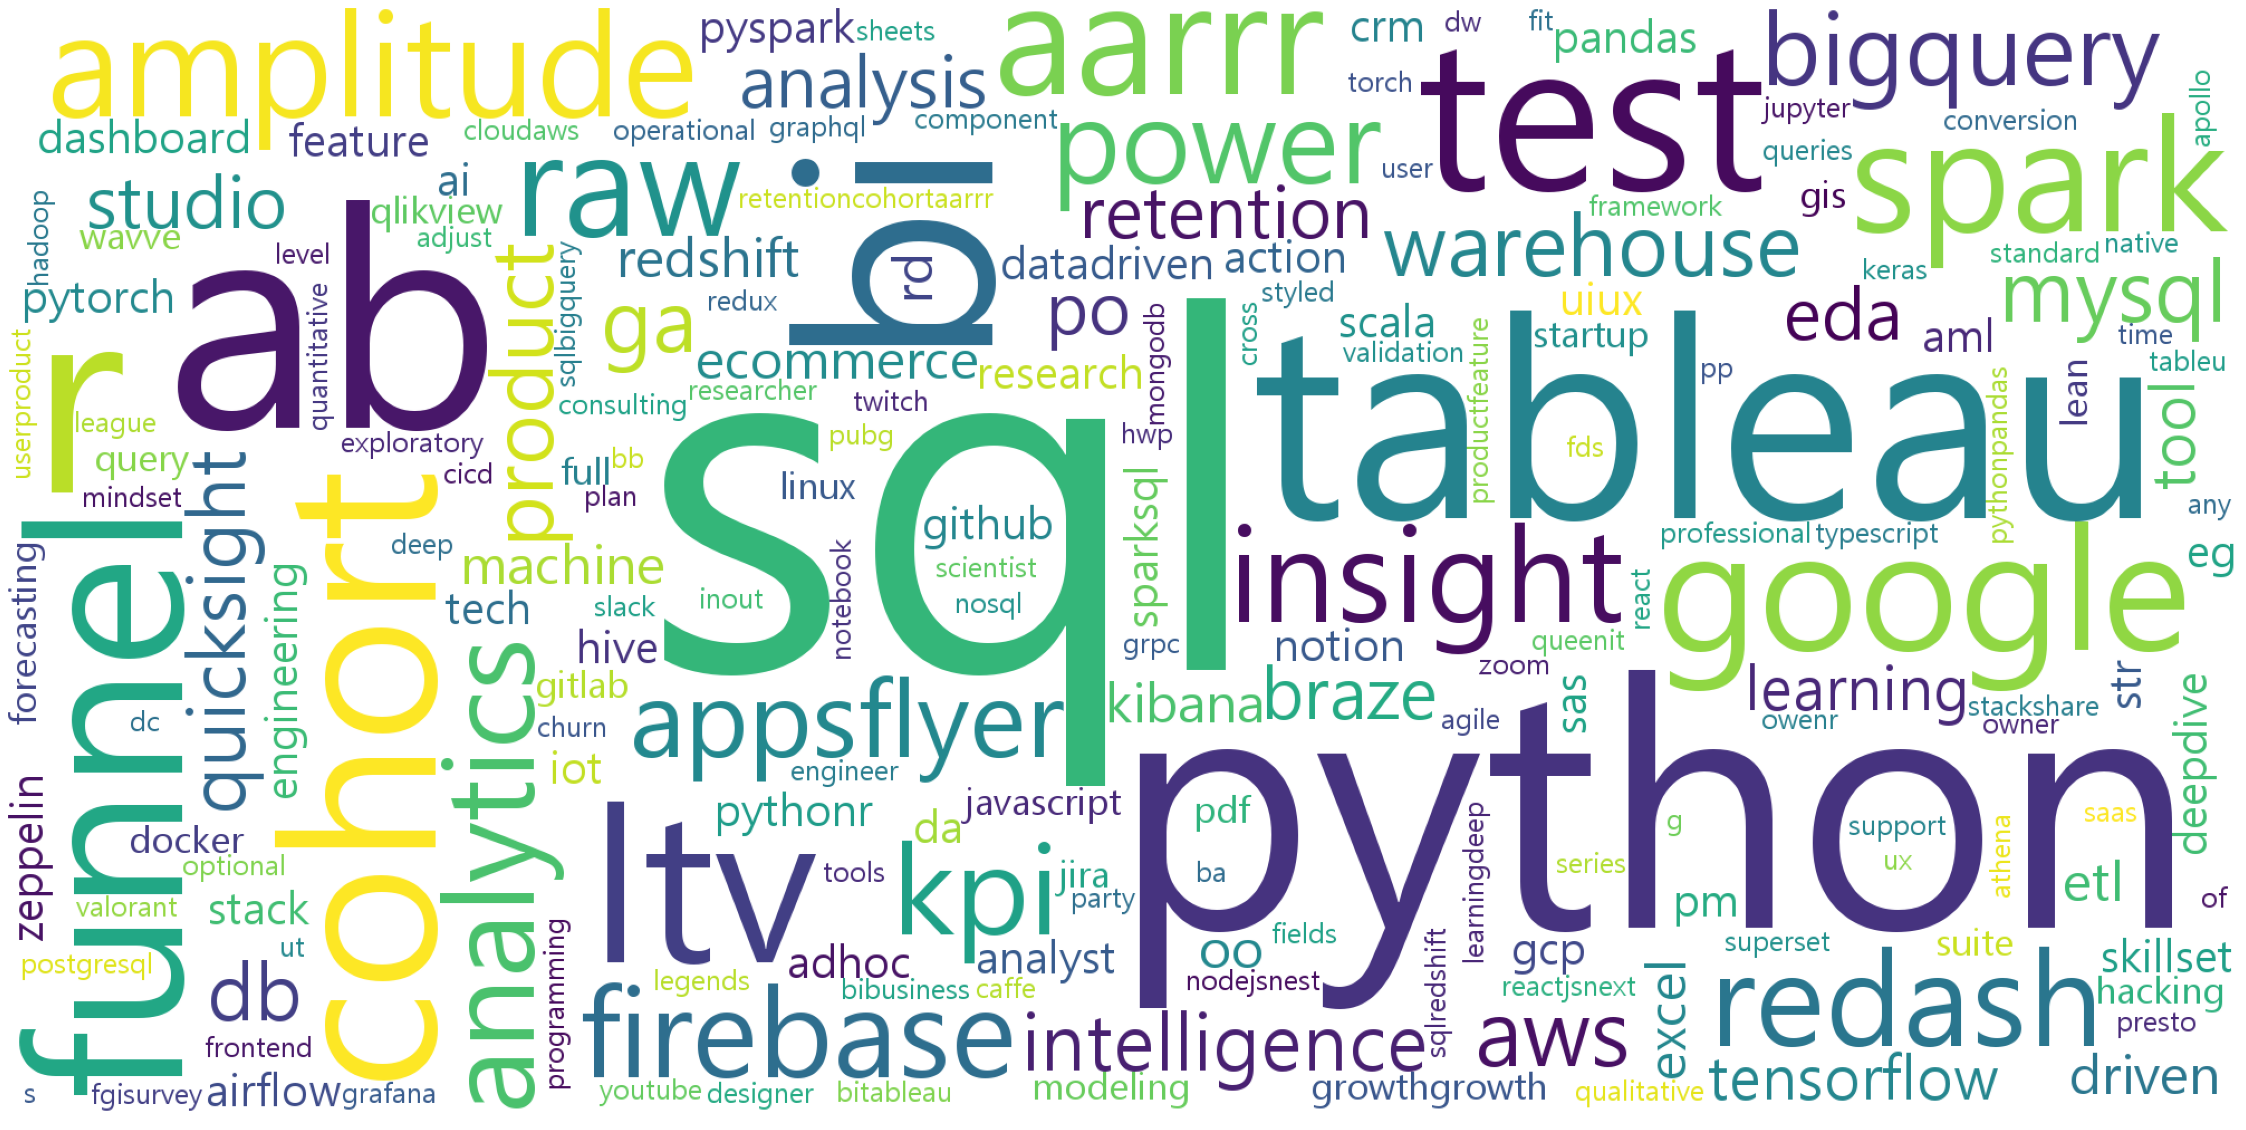

In [55]:
# wordcloud 만들기
wc = WordCloud(font_path = 'C:\Windows\Fonts\malgun.ttf',background_color="white",width=2000, height=1000).generate_from_frequencies(cleaned_counted_ranked) # font 경로 개별적으로 설정해야함
plt.figure(figsize = (40,40))
plt.imshow(wc)
plt.axis('off')
plt.show()

### 3.3 Barplot

In [347]:
df_count = pd.DataFrame.from_dict(cleaned_counted_ranked,orient='index') # 단어별 빈도 수를 데이터프레임으로 저장

In [348]:
df_count['skill'] = df_count.index # index로 들어있는 skill들을 컬럼으로 추가
df_count=df_count.rename(columns={0:'count'}) # 빈도 수 열이름 count로 변경

In [349]:
df_count = df_count[['skill','count']] # 컬럼 순서 변경


In [350]:
df_count.reset_index(inplace=True,drop=True) # 기존 인덱스 리셋 -> 내림차순 정렬로 새로운 index가 순위의 의미를 가짐

In [351]:
df_count2 = df_count[df_count['count']>=10] # 10회 이상 등장한 skill로 barplot 그리기 위함
df_count2

,skill,count
0,sql,54
1,python,43
2,ab,33
3,tableau,27
4,bi,26
5,r,26
6,cohort,15
7,funnel,15
8,ltv,15
9,test,15


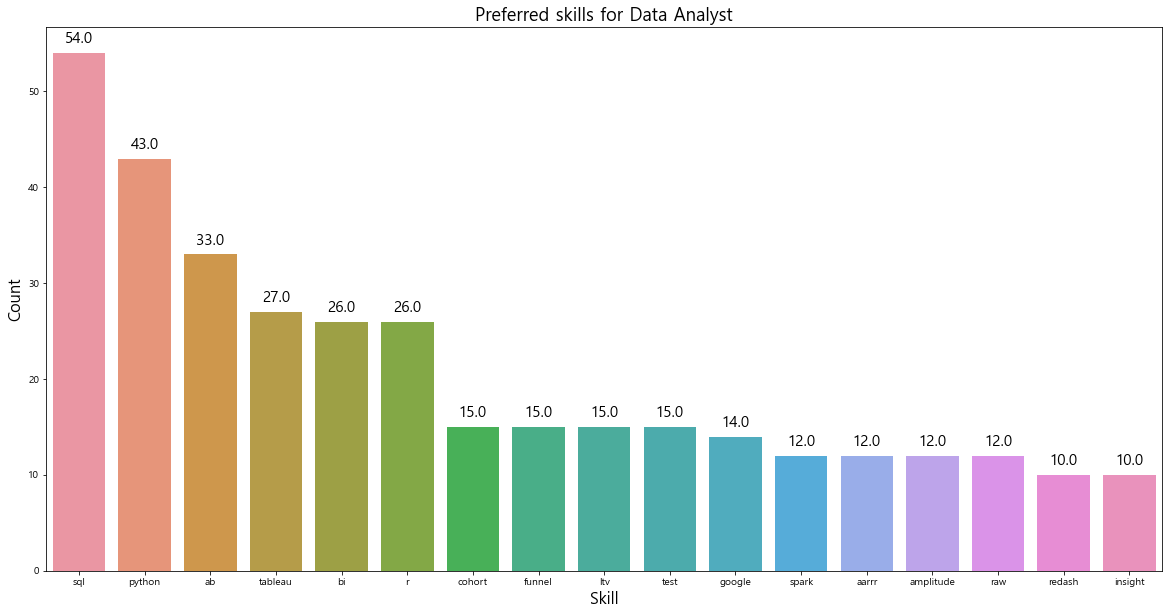

In [352]:
plt.figure(figsize=(20, 10))
bar=sns.barplot(data=df_count2,x='skill',y='count')
bar.set_title('Preferred skills for Data Analyst', fontsize=18)
bar.set_xlabel('Skill', fontdict={'size':16})                  
bar.set_ylabel('Count', fontdict={'size':16}) 
for p in bar.patches: # annotation
    height = p.get_height()
    bar.text(p.get_x() + p.get_width() / 2., height + 1, height, ha = 'center', size = 15,)
plt.show()

## 4. 빈출 keyword 분석(한글 명사 추출 및 분석 )

#### 4.1 데이터 전처리

In [56]:
# 형태소 분석기를 통해 명사만 추출하는 함수
def tokenizer_konlpy(text):
    okt=Okt()  
    return [word for word in okt.nouns(text) if len(word)>1] # 한 글자 명사는 제외
noun = tokenizer_konlpy(text)
print(noun)

['경쟁', '분석', '마케팅', '데이터', '활용', '전략', '수립', '실행', '서비스', '데이터', '분석', '가공', '매출', '결제', '데이터', '기반', '분석', '업무', '데이터', '통한', '분석', '시사', '발굴', '분석', '서비스', '적용', '방안', '수립', '수요', '예측', '개인화', '추천', '기반', '분석', '컨설팅', '머신', '러닝', '러닝', '활용', '데이터', '분석', '분석', '결과', '기반', '인사이트', '도출', '시각', '리포트', '경력', '데이터', '분석', '경험', '신입', '경력', '미만', '데이터', '분석', '통해', '가설', '이론', '수립', '시장', '사업', '적용', '경험', '이용', '데이터', '조회', '추출', '분석', '데이터', '기반', '수익', '모델', '수립', '거나', '운영', '통계', '분석', '관련', '업무', '지식', '프로그램', '운용', '능력', '데이터', '분석', '관련', '직무', '경험', '관련', '업무', '데이터', '시각', '프로그래밍', '경험', '기반', '커머스', '개인화', '데이터', '분석', '경험', '탐색', '데이터', '분석', '시계열', '데이터', '분석', '경험', '개발', '개발', '커뮤니케이션', '협업', '능력', '설득', '대화', '능력', '데이터', '기반', '의사소통', '능력', '데이터', '추출', '분석', '고객', '행동', '대한', '가설', '검증', '주요', '인사이트', '도출', '데이터', '분석', '기반', '비즈니스', '성장', '액션', '플랜', '제안', '개발', '개발', '관계자', '상황', '지표', '안내', '서비스', '현황', '성과', '분석', '정의', '활용', '대시보드', '제작', '데이터', '엔지니어', '협업', '서비스', 

In [57]:
# 추출한 명사의 빈도 수 세기
kor_counted = Counter(noun)

In [58]:
# 빈도수 상위 100개를 내림차순으로 표시
kor_counted_ranked = kor_counted.most_common(100)
kor_counted_ranked

[('데이터', 495),
 ('분석', 394),
 ('경험', 231),
 ('서비스', 106),
 ('관련', 103),
 ('대한', 101),
 ('기반', 96),
 ('활용', 87),
 ('설계', 66),
 ('결과', 65),
 ('업무', 60),
 ('인사이트', 60),
 ('지표', 57),
 ('이상', 57),
 ('개선', 55),
 ('문제', 54),
 ('시각', 52),
 ('능력', 49),
 ('비즈니스', 46),
 ('개발', 45),
 ('사용', 45),
 ('경력', 44),
 ('이해', 44),
 ('도출', 43),
 ('해결', 42),
 ('통해', 41),
 ('통계', 39),
 ('지원', 38),
 ('역량', 38),
 ('마케팅', 37),
 ('관리', 34),
 ('통한', 33),
 ('가설', 33),
 ('이해도', 31),
 ('가공', 30),
 ('추출', 30),
 ('지식', 30),
 ('의사결정', 30),
 ('진행', 30),
 ('검증', 29),
 ('정의', 29),
 ('보유', 29),
 ('실험', 29),
 ('운영', 28),
 ('커뮤니케이션', 28),
 ('대시보드', 27),
 ('실무', 27),
 ('처리', 26),
 ('서류', 25),
 ('구축', 24),
 ('테스트', 24),
 ('유저', 24),
 ('성과', 23),
 ('로그', 23),
 ('게임', 23),
 ('수립', 22),
 ('적용', 22),
 ('협업', 22),
 ('환경', 22),
 ('면접', 22),
 ('프로젝트', 22),
 ('이용', 21),
 ('사용자', 21),
 ('통계학', 21),
 ('제공', 21),
 ('논리', 20),
 ('사고', 20),
 ('고객', 19),
 ('기획', 19),
 ('방법', 19),
 ('전형', 19),
 ('러닝', 18),
 ('사업', 18),
 ('공유', 18),
 ('위해', 18)

In [356]:
stop_words = ['데이터','분석','대한','관련','기반','이상','통해','통한','프로','덕트','위해',]  # 불용어 사전 만들기
# '데이터', '분석'은 검색 키워드라 제거한다. 많은 빈도수를 가지지만 분석의 의미가 없다.

In [357]:
cleaned_kor = [word for word in noun if not word in stop_words] #불용어 제거
cleaned_kor

['경쟁',
 '마케팅',
 '활용',
 '전략',
 '수립',
 '실행',
 '서비스',
 '가공',
 '매출',
 '결제',
 '업무',
 '시사',
 '발굴',
 '서비스',
 '적용',
 '방안',
 '수립',
 '수요',
 '예측',
 '개인화',
 '추천',
 '컨설팅',
 '머신',
 '러닝',
 '러닝',
 '활용',
 '결과',
 '인사이트',
 '도출',
 '시각',
 '리포트',
 '경력',
 '경험',
 '신입',
 '경력',
 '미만',
 '가설',
 '이론',
 '수립',
 '시장',
 '사업',
 '적용',
 '경험',
 '이용',
 '조회',
 '추출',
 '수익',
 '모델',
 '수립',
 '거나',
 '운영',
 '통계',
 '업무',
 '지식',
 '프로그램',
 '운용',
 '능력',
 '직무',
 '경험',
 '업무',
 '시각',
 '프로그래밍',
 '경험',
 '커머스',
 '개인화',
 '경험',
 '탐색',
 '시계열',
 '경험',
 '개발',
 '개발',
 '커뮤니케이션',
 '협업',
 '능력',
 '설득',
 '대화',
 '능력',
 '의사소통',
 '능력',
 '추출',
 '고객',
 '행동',
 '가설',
 '검증',
 '주요',
 '인사이트',
 '도출',
 '비즈니스',
 '성장',
 '액션',
 '플랜',
 '제안',
 '개발',
 '개발',
 '관계자',
 '상황',
 '지표',
 '안내',
 '서비스',
 '현황',
 '성과',
 '정의',
 '활용',
 '대시보드',
 '제작',
 '엔지니어',
 '협업',
 '서비스',
 '구조',
 '축적',
 '소스',
 '매핑',
 '아키텍쳐',
 '기획',
 '모바일',
 '고객',
 '행동',
 '서비스',
 '개선',
 '경험',
 '처리',
 '언어',
 '지식',
 '보유',
 '전문가',
 '사용자',
 '행동',
 '인사이트',
 '개선',
 '서비스',
 '적용',
 '경험',
 '변화',
 '환경',
 '서비스',
 '열정',
 '가지'

In [358]:
# 각각 전처리가 완료된 영어 토큰 리스트 word_tokens와 한글 토큰 리스트 cleaned_kor를 합쳐서 전체 리스트를 만든다.
cleaned_all = word_tokens + cleaned_kor 
len(cleaned_all)

5980

In [359]:
# 전체 리스트 빈도 수 
counted_all = Counter(cleaned_all)
counted_all_ranked = dict(counted_all.most_common())
counted_all_ranked

{'경험': 231,
 '서비스': 106,
 '활용': 87,
 '설계': 66,
 '결과': 65,
 '업무': 60,
 '인사이트': 60,
 '지표': 57,
 '개선': 55,
 'sql': 54,
 '문제': 54,
 '시각': 52,
 '능력': 49,
 '비즈니스': 46,
 '개발': 45,
 '사용': 45,
 '경력': 44,
 '이해': 44,
 'python': 43,
 '도출': 43,
 '해결': 42,
 '통계': 39,
 '지원': 38,
 '역량': 38,
 '마케팅': 37,
 '관리': 34,
 'ab': 33,
 '가설': 33,
 '이해도': 31,
 '가공': 30,
 '추출': 30,
 '지식': 30,
 '의사결정': 30,
 '진행': 30,
 '검증': 29,
 '정의': 29,
 '보유': 29,
 '실험': 29,
 '운영': 28,
 '커뮤니케이션': 28,
 'tableau': 27,
 '대시보드': 27,
 '실무': 27,
 'bi': 26,
 'r': 26,
 '처리': 26,
 '서류': 25,
 '구축': 24,
 '테스트': 24,
 '유저': 24,
 '성과': 23,
 '로그': 23,
 '게임': 23,
 '수립': 22,
 '적용': 22,
 '협업': 22,
 '환경': 22,
 '면접': 22,
 '프로젝트': 22,
 '이용': 21,
 '사용자': 21,
 '통계학': 21,
 '제공': 21,
 '논리': 20,
 '사고': 20,
 '고객': 19,
 '기획': 19,
 '방법': 19,
 '전형': 19,
 '러닝': 18,
 '사업': 18,
 '공유': 18,
 '행동': 17,
 '주요': 17,
 '모바일': 17,
 '언어': 17,
 '부서': 17,
 '실행': 16,
 '발굴': 16,
 '직무': 16,
 '유관': 16,
 '제품': 16,
 '분야': 16,
 '전달': 16,
 'cohort': 15,
 'funnel': 15,
 'ltv': 15,
 '

#### 4.2 Wordcloud

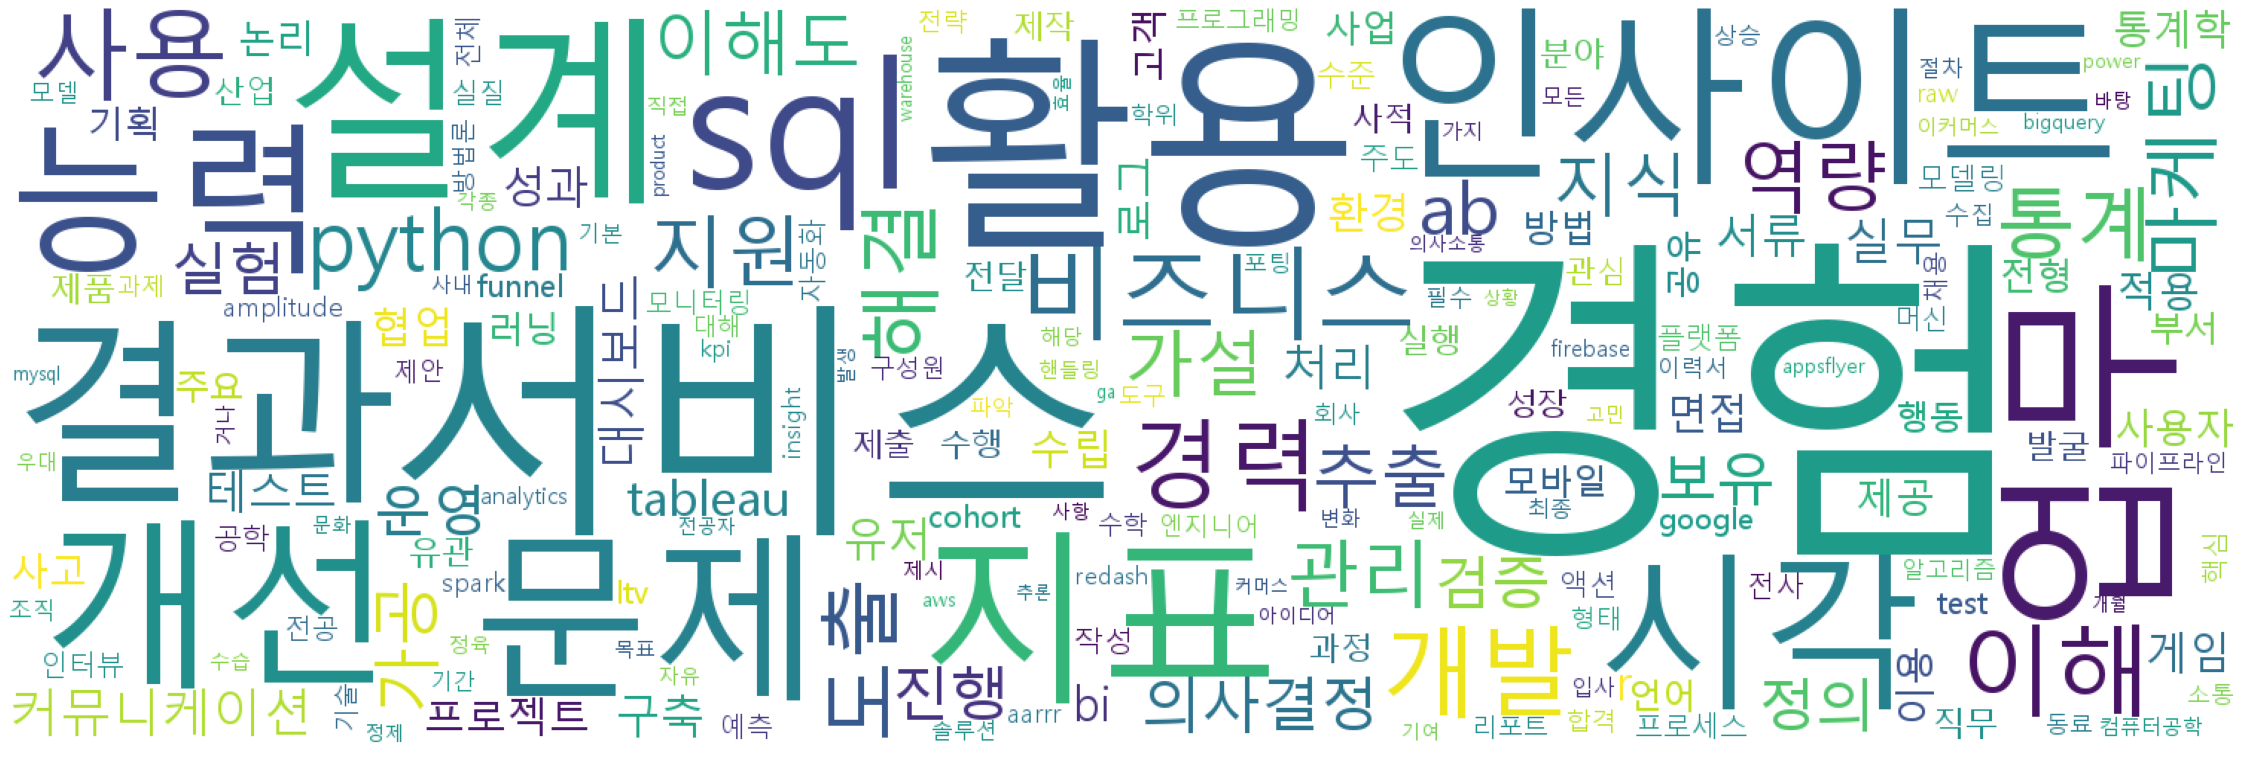

In [360]:
#wordcloud 만들기
wc = WordCloud(font_path = 'C:\Windows\Fonts\malgun.ttf',background_color="white",width=1500, height=500).generate_from_frequencies(counted_all_ranked) # font 경로 개별적으로 설정해야함
plt.figure(figsize = (40,40))
plt.imshow(wc)
plt.axis('off')
plt.show()

### 4.3 Barplot

In [361]:
df_keyword = pd.DataFrame.from_dict(counted_all_ranked,orient='index')

In [362]:
df_keyword

,0
경험,231
서비스,106
활용,87
설계,66
결과,65
...,...
화상,1
대면,1
검사,1
레포트,1


In [363]:
df_keyword['keyword'] = df_keyword.index
df_keyword

,0,keyword
경험,231,경험
서비스,106,서비스
활용,87,활용
설계,66,설계
결과,65,결과
...,...,...
화상,1,화상
대면,1,대면
검사,1,검사
레포트,1,레포트


In [364]:
df_keyword=df_keyword.rename(columns={0:'count'})
df_keyword = df_keyword[['keyword','count']]
df_keyword

,keyword,count
경험,경험,231
서비스,서비스,106
활용,활용,87
설계,설계,66
결과,결과,65
...,...,...
화상,화상,1
대면,대면,1
검사,검사,1
레포트,레포트,1


In [365]:
df_keyword.reset_index(drop=True,inplace=True) #  drop=True 기존 인덱스 삭제 

In [366]:
df_keyword

,keyword,count
0,경험,231
1,서비스,106
2,활용,87
3,설계,66
4,결과,65
...,...,...
1264,화상,1
1265,대면,1
1266,검사,1
1267,레포트,1


In [371]:
df_keyword2 = df_keyword[df_keyword['count']>=30]
df_keyword2

,keyword,count
0,경험,231
1,서비스,106
2,활용,87
3,설계,66
4,결과,65
5,업무,60
6,인사이트,60
7,지표,57
8,개선,55
9,sql,54


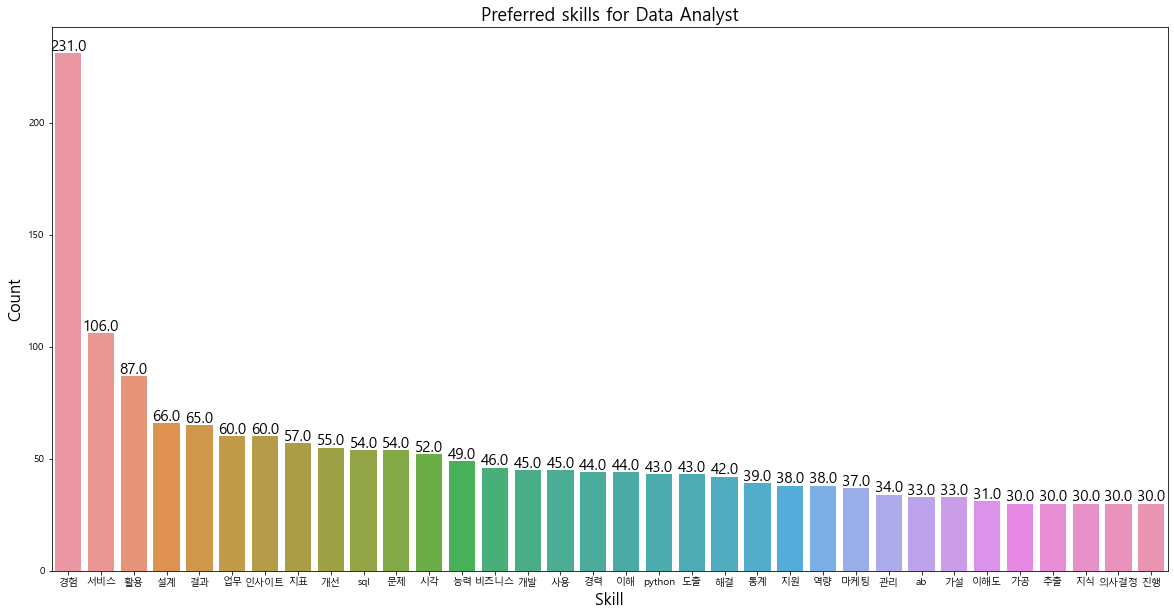

In [372]:
plt.figure(figsize=(20, 10))
bar=sns.barplot(data=df_keyword2,x='keyword', y='count')
bar.set_title('Preferred skills for Data Analyst', fontsize=18)
bar.set_xlabel('Skill', fontdict={'size':16})                   # x축 이름
bar.set_ylabel('Count', fontdict={'size':16}) 
for p in bar.patches: # count 넣기
    height = p.get_height()
    bar.text(p.get_x() + p.get_width() / 2., height + 1, height, ha = 'center', size = 15,)
plt.show()